- Thuật toán sử dung: neural network đơn giản chỉ gồm một lớp softmax, lý do sử dụng:
    - Tập dữ liệu đối với tập train bị mất cân bằng có những nhãn rất ít mẫu, do đó một mô hình mạng phức tạp rất dễ gây overfit.
    - Đây là bài toán phân loại với nhiều nhãn, ta không cần quan tâm quá nhiều đến vị trí từ trong các câu do đó việc sử dụng các thuật toán hay sử dụng cho chuỗi như LSTM là không cần thiết.Ta cần vector hóa các mãu đào tạo cộng với việc ta cần quan tâm là làm sao để có được keyword phân biệt giữa các nhãn => sử dụng tfidf là phù hợp.
    - Neural network là một thuật toán rất dễ fit với dữ liệu đào tạo. Do đặc thù của thuật toán vector hóa mà mỗi mẫu sau khi vector hóa sẽ có rất nhiều phần tử 0 (những từ không có trong mẫu), những input nào bằng 0 thì weight sẽ hầu như không được cập nhật đồng nghĩa với việc những từ nào mà trong mẫu có sẽ được cập nhật weight tại đó.
    - Sau khi vector hóa các mẫu, tập dữ liệu sẽ có chiều rất lớn, do đó nếu sử một số thuật toán thường gặp như KNN hay SVM sẽ không phù hợp, đối với KNN thì chỉ hiệu quả với tập dữ liệu chiều thấp và đối với dữ liệu chiều cao như trong bài toán KNN sẽ phải tính toán một lượng rất lớn, đối với SVM việc tính toán với dữ liệu chiều cao sẽ rất lâu. Một thuật toán hay sử dụng khác là Random forest đối với dữ liệu imbalance, nhưng qua thử nghiệm hiện tại thuật toán này cho kết quả chưa tốt bằng so với sử dụng neural network.
- Kết quả: 
    - Accuracy đối với tập test khoảng 0.916 và train là 0.986. Kết quả này đang bị overfit nhưng đã hạn chế hơn rất nhiều so với khi sử dụng các thuật toán khác.
    - Việc sử dụng k fold hiện tại chưa cải thiện được kết quả.
- Một số phương pháp có thể thử nghiệm để cải thiện model:
    - Sử dụng word embedding.
    - Tăng thêm lượng dữ liệu đối với các nhãn có kết quả thấp.
    - Sử dụng thêm nhiều thuật toán khác, nếu các thuật toán này có kết quả tốt hơn hoặc bằng kết quả hiện tại thì có thể dùng voting hoặc một cách khác là sử dụng Ensemble model.
    

In [1]:
import pandas as pd
import numpy as np
import os
from keras.models import Model
import re
from pyvi import ViTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import numpy as np
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# 1. Data Processing 

In [5]:
def text_process(txt):
    txt = txt.lower()
    txt = re.sub('[\d\'\\\.\,\#\$\%\^\&\*\(\)\!\+\-\_\"\:\?\<\>\{\}\[\];\(\)]','',txt)
    txt = re.sub('(\\r\\n)|[\/]',' ',txt)
    txt = re.sub('[^zxcvbnmasdfghjklqwertyuiop\sàáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ]','',txt)
    
    return txt

def word_separation(txt):
    return ViTokenizer.tokenize(txt)

def pad(tokenizer, sequences, max_length, trunc_type):
    sequences = tokenizer.texts_to_sequences(sequences)
    padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type)
    return padded

def remove_stop_word(txt):
    stop_words = ['của', 'và', 'có', 'là', 'một', 'trong', 'không', 'các', 'được', 'cho', 'với', 'những', 'người', 'đã', 'tôi', 'khi', 'này', 'ở', 'để', 'sẽ', 'công', 'cũng', 'học', 'thể', 'như', 'vào', 'đến', 'ra', 'làm', 'về', 'phải', 'nhiều', 'từ', 'đó', 'đầu', 'anh', 'năm', 'nhưng', 'tại', 'lại', 'chỉ', 'nhà', 'thành', 'sự', 'trên', 'sau', 'số', 'còn', 'hiện', 'gia']
    words = []
    for word in txt.strip().split():
        if word not in stop_words:
            words.append(word)
    return ' '.join(words)

def read_data(path_foder):
    data = {}
    content = []
    label = []
    typee = []
    for path in path_foder:
        for direc_name in os.listdir(path):
            for file_name in os.listdir(path + '/' + direc_name):
                with open(path + '/' + direc_name + '/' + file_name,'rb') as f:
                    file = f.read()
                    file = file.decode("utf-16").strip()
                    content.append(file)
                    label.append(direc_name)
                    typee.append(path)

    data['content'] = content
    data['label'] = label
    data['type'] = typee
    df = pd.DataFrame(data)
    return df

def get_model():
    model = Sequential()
    model.add(Dense(27, activation = 'softmax', input_dim=X_train.shape[1], kernel_regularizer = regularizers.l2(0.00001)))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
    
    return model

In [29]:
# read data
path_foder = ['train', 'test']
df = read_data(path_foder)

## 1.1 Loại bỏ các kí tự không cần thiết

In [30]:
# loại bỏ các kí tự không cần thiết
df["new_content"] = df.content.apply(text_process)

## 1.2 Tách từ

In [32]:
# tách từ
df["word_separation"] = df.new_content.apply(word_separation)

## 1.3 Đếm số lượng từ mỗi mẫu

In [33]:
# đếm số lượng từ ở mỗi sample
df["number_word"] = df.word_separation.apply(lambda txt: len(txt.split(' ')))

## 1.4 Tìm Stop word

In [34]:
df_train = df.where(df.type == 'train').dropna()
vocab_size = 50000
tokenizer = Tokenizer(num_words = vocab_size, filters='')
tokenizer.fit_on_texts(df_train.new_content)
word_index = tokenizer.word_index
stop_words = list(word_index)[:50]

## 1.5 Loại bỏ Stop word

In [35]:
df["remove_stop_word"] = df.word_separation.apply(remove_stop_word)
df["number_word_remove_stop_word"] = df.remove_stop_word.apply(lambda txt: len(txt.split(' ')))
df

,content,label,type,new_content,word_separation,number_word,remove_stop_word,number_word_remove_stop_word
0,"Đó là chủ đề liveshow Sắc màu âm nhạc tháng 4,...",Am nhac,train,đó là chủ đề liveshow sắc màu âm nhạc tháng s...,đó là chủ_đề liveshow sắc_màu âm_nhạc tháng sẽ...,73,chủ_đề liveshow sắc_màu âm_nhạc tháng diễn lúc...,54
1,"Giống như Keiko Matsui, Blackmore's Night được...",Am nhac,train,giống như keiko matsui blackmores night được h...,giống như keiko matsui blackmores night được h...,694,giống keiko matsui blackmores night hầu_hết bá...,506
2,Vừa trở về Việt Nam sau chuyến lưu diễn 3 tuần...,Am nhac,train,vừa trở về việt nam sau chuyến lưu diễn tuần ...,vừa trở về việt nam sau chuyến lưu_diễn tuần t...,346,vừa trở việt nam chuyến lưu_diễn tuần mỹ ca_sĩ...,229
3,Chương trình ca nhạc mừng sinh nhật lần thứ 20...,Am nhac,train,chương trình ca nhạc mừng sinh nhật lần thứ c...,chương_trình ca_nhạc mừng sinh_nhật lần thứ củ...,118,chương_trình ca_nhạc mừng sinh_nhật lần thứ đo...,108
4,"""Ta là một khách mày râu/Đứng đi lạng chạng dư...",Am nhac,train,ta là một khách mày râu đứng đi lạng chạng dướ...,ta là một khách mày râu đứng đi lạng chạng dướ...,476,ta khách mày râu đứng đi lạng chạng dưới bầu_t...,304
...,...,...,...,...,...,...,...,...
26446,Trương Thanh Long: 'Bạn bè bảo tôi là bon chen...,Thoi trang,test,trương thanh long bạn bè bảo tôi là bon chen s...,trương thanh_long bạn_bè bảo tôi là bon_chen s...,551,trương thanh_long bạn_bè bảo bon_chen đoạt giả...,357
26447,Người đẹp dễ dụ bằng tiền\r\nKhông phải ngẫu n...,Thoi trang,test,người đẹp dễ dụ bằng tiền không phải ngẫu nhiê...,người đẹp dễ dụ bằng tiền không phải ngẫu_nhiê...,1036,đẹp dễ dụ bằng tiền ngẫu_nhiên mà đa_số đẹp đă...,671
26448,21 người đẹp vào vòng chung kết Hoa hậu toàn q...,Thoi trang,test,người đẹp vào vòng chung kết hoa hậu toàn quố...,người đẹp vào vòng chung_kết hoa_hậu toàn_quốc...,220,đẹp vòng chung_kết hoa_hậu toàn_quốc đêm khai_...,146
26449,'Hoa hậu phải rành ngoại ngữ'\r\nNữ hoàng sắc ...,Thoi trang,test,hoa hậu phải rành ngoại ngữ nữ hoàng sắc đẹp v...,hoa_hậu phải rành ngoại_ngữ nữ_hoàng sắc_đẹp v...,358,hoa_hậu rành ngoại_ngữ nữ_hoàng sắc_đẹp việt n...,250


# 2. Data preparation

In [36]:
# df = pd.read_csv('data.csv', encoding='utf-16')
df_train = df.where(df.type == 'train').dropna()
df_test = df.where(df.type == 'test').dropna()

<AxesSubplot:>

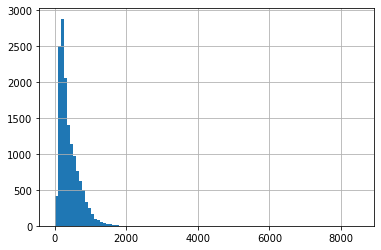

In [37]:
df_train["number_word"].hist(bins=100)

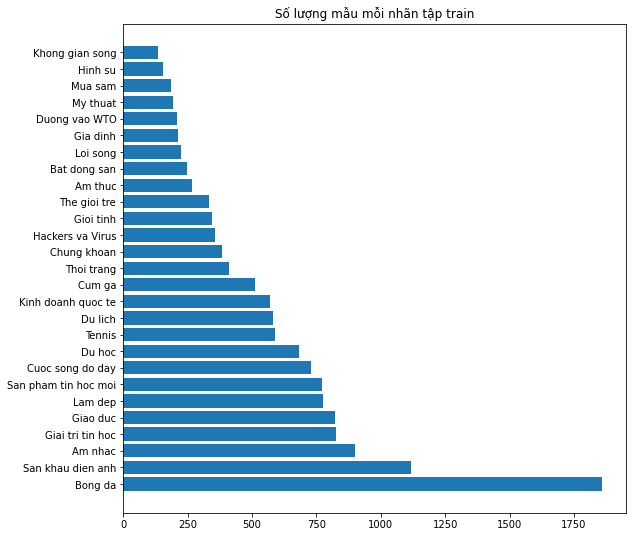

In [38]:
number_per_label = df_train.label.value_counts()
fig, ax = plt.subplots()
fig.set_size_inches(9,9)
ax.barh(y=number_per_label.index, width=number_per_label.values);
ax.set_title('Số lượng mẫu mỗi nhãn tập train');

## 2.1 TF-IDF

In [39]:
tfIdfVectorizer = TfidfVectorizer(encoding = 'utf-16',min_df=5, use_idf=True)
tfIdf = tfIdfVectorizer.fit(df_train.remove_stop_word)

## 2.2  X_train, y_train, X_test, y_test

In [40]:
X_train  = tfIdf.transform(df_train.remove_stop_word).toarray()
X_test  = tfIdf.transform(df_test.remove_stop_word).toarray()

In [41]:
lb = LabelEncoder().fit(df_train.label.values)

In [42]:
y_train  = lb.transform(df_train.label.values)
y_test = lb.transform(df_test.label.values)

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# 3.Training

##  3.1 neural network

In [4]:
checkpoint_path = 'model_checkpoints'
checkpoint = ModelCheckpoint(
                filepath = checkpoint_path,
                save_weights_only = False,
                monitor = 'val_accuracy',
                mode = 'max',
                save_best_only=True,
                verbose=1
            )

In [24]:
model = get_model()

In [250]:
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=checkpoint)

Epoch 1/50
450/450 [==============================] - 4s 9ms/step - loss: 2.9332 - accuracy: 0.4812 - val_loss: 2.2226 - val_accuracy: 0.6578

Epoch 00001: val_accuracy improved from -inf to 0.65775, saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints\assets
Epoch 2/50
450/450 [==============================] - 4s 8ms/step - loss: 1.9321 - accuracy: 0.7483 - val_loss: 1.7141 - val_accuracy: 0.7556

Epoch 00002: val_accuracy improved from 0.65775 to 0.75563, saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints\assets
Epoch 3/50
450/450 [==============================] - 4s 8ms/step - loss: 1.4582 - accuracy: 0.8292 - val_loss: 1.4254 - val_accuracy: 0.8085

Epoch 00003: val_accuracy improved from 0.75563 to 0.80846, saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints\assets
Epoch 4/50
450/450 [==============================] - 4s 8ms/step - loss: 1.1831 - accuracy: 0.8821 - val_loss: 

In [26]:
best_model  = load_model(checkpoint_path)
y_pred = best_model.predict_classes(X_test)
print(metrics.classification_report(y_test, y_pred, target_names= lb.classes_))

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


                      precision    recall  f1-score   support

             Am nhac       0.92      0.93      0.93       813
             Am thuc       0.98      0.93      0.95       400
        Bat dong san       0.99      0.94      0.97       282
             Bong da       0.99      1.00      0.99      1464
         Chung khoan       0.99      0.96      0.97       320
              Cum ga       1.00      0.98      0.99       381
    Cuoc song do day       0.66      0.90      0.76       405
              Du hoc       0.98      0.92      0.95       394
             Du lich       0.92      0.96      0.94       565
       Duong vao WTO       0.99      0.83      0.90       191
            Gia dinh       0.88      0.61      0.72       280
    Giai tri tin hoc       0.78      0.92      0.85       707
            Giao duc       0.92      0.93      0.93       707
           Gioi tinh       0.89      0.93      0.91       268
    Hackers va Virus       1.00      0.87      0.93       319
       

In [27]:
test = tfIdf.transform(['áo đẹp quá']).toarray()
pred = model.predict_classes(test)
print(lb.classes_[pred])

['Thoi trang']


## 3.2 Sử dụng K-ford

In [85]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle = True)
data = {}
i = 0
loss_list = []
accuracy_list = []
model_list = {}
for train_index, val_index in skf.split(X_train, y_train):
    print("TRAIN:", train_index, "TEST:", val_index)
    data['X_train' + str(i)], data['X_val' + str(i)]= X_train[train_index], X_train[val_index]
    data['y_train' + str(i)], data['y_val' + str(i)] = y_train[train_index], y_train[val_index]
    
    model = get_model()
    # Train model
    model.fit(data['X_train' + str(i)], data['y_train' + str(i)],
              batch_size=32,
              epochs=30,
              validation_data=(data['X_val' + str(i)], data['y_val' + str(i)]),
              verbose=1)
    
    # Test và in kết quả
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Đã train xong Fold ", i)

    # Thêm thông tin accuracy và loss vào list
    accuracy_list.append(scores[1] * 100)
    loss_list.append(scores[0])
    model_list["model" + str(i)] = model
    
    i = i + 1
    
# In kết quả tổng thể
print('* Chi tiết các fold')
for i in range(0, len(accuracy_list)):
    print(f'> Fold {i+1} - Loss: {loss_list[i]} - Accuracy: {accuracy_list[i]}%')

print('* Đánh giá tổng thể các folds:')
print(f'> Accuracy: {np.mean(accuracy_list)} (Độ lệch +- {np.std(accuracy_list)})')
print(f'> Loss: {np.mean(loss_list)}')


pred = 0
for model in model_list:
    pred += model_list[model].predict(X_test)*0.1
    
label_pred = np.argmax(pred, axis = 1)
print(metrics.classification_report(y_test, label_pred, target_names= lb.classes_))

TRAIN: [    0     1     2 ... 14371 14373 14374] TEST: [   20    21    58 ... 14353 14367 14372]
Epoch 1/30
405/405 [==============================] - 4s 10ms/step - loss: 2.9655 - accuracy: 0.4983 - val_loss: 2.2079 - val_accuracy: 0.6676
Epoch 2/30
405/405 [==============================] - 3s 7ms/step - loss: 2.0194 - accuracy: 0.7324 - val_loss: 1.6808 - val_accuracy: 0.7747
Epoch 3/30
405/405 [==============================] - 3s 8ms/step - loss: 1.5306 - accuracy: 0.8216 - val_loss: 1.3783 - val_accuracy: 0.8213
Epoch 4/30
405/405 [==============================] - 3s 7ms/step - loss: 1.2444 - accuracy: 0.8773 - val_loss: 1.1918 - val_accuracy: 0.8581
Epoch 5/30
405/405 [==============================] - 3s 8ms/step - loss: 1.0546 - accuracy: 0.9088 - val_loss: 1.0686 - val_accuracy: 0.8762
Epoch 6/30
405/405 [==============================] - 3s 7ms/step - loss: 0.9351 - accuracy: 0.9278 - val_loss: 0.9816 - val_accuracy: 0.8839
Epoch 7/30
405/405 [==============================

Epoch 27/30
405/405 [==============================] - 3s 7ms/step - loss: 0.4499 - accuracy: 0.9823 - val_loss: 0.5985 - val_accuracy: 0.9124
Epoch 28/30
405/405 [==============================] - 3s 6ms/step - loss: 0.4426 - accuracy: 0.9827 - val_loss: 0.5947 - val_accuracy: 0.9124
Epoch 29/30
405/405 [==============================] - 3s 7ms/step - loss: 0.4383 - accuracy: 0.9816 - val_loss: 0.5914 - val_accuracy: 0.9117
Epoch 30/30
405/405 [==============================] - 3s 7ms/step - loss: 0.4312 - accuracy: 0.9832 - val_loss: 0.5881 - val_accuracy: 0.9131
Đã train xong Fold  1
TRAIN: [    0     1     2 ... 14372 14373 14374] TEST: [   29    30    33 ... 14338 14364 14366]
Epoch 1/30
405/405 [==============================] - 14s 9ms/step - loss: 2.9650 - accuracy: 0.4974 - val_loss: 2.2133 - val_accuracy: 0.6829
Epoch 2/30
405/405 [==============================] - 3s 7ms/step - loss: 2.0178 - accuracy: 0.7410 - val_loss: 1.6893 - val_accuracy: 0.7698
Epoch 3/30
405/405 [====

Epoch 23/30
405/405 [==============================] - 3s 6ms/step - loss: 0.4684 - accuracy: 0.9801 - val_loss: 0.6395 - val_accuracy: 0.9131
Epoch 24/30
405/405 [==============================] - 22s 54ms/step - loss: 0.4612 - accuracy: 0.9809 - val_loss: 0.6342 - val_accuracy: 0.9124
Epoch 25/30
405/405 [==============================] - 3s 7ms/step - loss: 0.4593 - accuracy: 0.9783 - val_loss: 0.6296 - val_accuracy: 0.9124
Epoch 26/30
405/405 [==============================] - 3s 7ms/step - loss: 0.4519 - accuracy: 0.9795 - val_loss: 0.6253 - val_accuracy: 0.9124
Epoch 27/30
405/405 [==============================] - 3s 7ms/step - loss: 0.4444 - accuracy: 0.9813 - val_loss: 0.6215 - val_accuracy: 0.9117
Epoch 28/30
405/405 [==============================] - 3s 6ms/step - loss: 0.4389 - accuracy: 0.9818 - val_loss: 0.6180 - val_accuracy: 0.9117
Epoch 29/30
405/405 [==============================] - 3s 6ms/step - loss: 0.4364 - accuracy: 0.9834 - val_loss: 0.6149 - val_accuracy: 0.91

Epoch 19/30
405/405 [==============================] - 3s 6ms/step - loss: 0.5037 - accuracy: 0.9779 - val_loss: 0.6711 - val_accuracy: 0.9144
Epoch 20/30
405/405 [==============================] - 3s 6ms/step - loss: 0.4915 - accuracy: 0.9775 - val_loss: 0.6628 - val_accuracy: 0.9137
Epoch 21/30
405/405 [==============================] - 3s 6ms/step - loss: 0.4821 - accuracy: 0.9775 - val_loss: 0.6553 - val_accuracy: 0.9130
Epoch 22/30
405/405 [==============================] - 3s 6ms/step - loss: 0.4748 - accuracy: 0.9796 - val_loss: 0.6484 - val_accuracy: 0.9144
Epoch 23/30
405/405 [==============================] - 3s 6ms/step - loss: 0.4705 - accuracy: 0.9807 - val_loss: 0.6425 - val_accuracy: 0.9137
Epoch 24/30
405/405 [==============================] - 3s 6ms/step - loss: 0.4582 - accuracy: 0.9819 - val_loss: 0.6369 - val_accuracy: 0.9144
Epoch 25/30
405/405 [==============================] - 3s 6ms/step - loss: 0.4539 - accuracy: 0.9818 - val_loss: 0.6321 - val_accuracy: 0.9137

Epoch 15/30
405/405 [==============================] - 3s 6ms/step - loss: 0.5596 - accuracy: 0.9706 - val_loss: 0.7218 - val_accuracy: 0.9095
Epoch 16/30
405/405 [==============================] - 3s 6ms/step - loss: 0.5477 - accuracy: 0.9717 - val_loss: 0.7080 - val_accuracy: 0.9109
Epoch 17/30
405/405 [==============================] - 3s 6ms/step - loss: 0.5250 - accuracy: 0.9745 - val_loss: 0.6956 - val_accuracy: 0.9102
Epoch 18/30
405/405 [==============================] - 3s 6ms/step - loss: 0.5180 - accuracy: 0.9731 - val_loss: 0.6844 - val_accuracy: 0.9109
Epoch 19/30
405/405 [==============================] - 3s 6ms/step - loss: 0.5078 - accuracy: 0.9769 - val_loss: 0.6748 - val_accuracy: 0.9144
Epoch 20/30
405/405 [==============================] - 3s 6ms/step - loss: 0.4931 - accuracy: 0.9769 - val_loss: 0.6662 - val_accuracy: 0.9130
Epoch 21/30
405/405 [==============================] - 3s 6ms/step - loss: 0.4869 - accuracy: 0.9770 - val_loss: 0.6582 - val_accuracy: 0.9144

Epoch 11/30
405/405 [==============================] - 2s 6ms/step - loss: 0.6579 - accuracy: 0.9630 - val_loss: 0.7857 - val_accuracy: 0.9109
Epoch 12/30
405/405 [==============================] - 2s 6ms/step - loss: 0.6277 - accuracy: 0.9658 - val_loss: 0.7622 - val_accuracy: 0.9130
Epoch 13/30
405/405 [==============================] - 3s 6ms/step - loss: 0.6020 - accuracy: 0.9679 - val_loss: 0.7420 - val_accuracy: 0.9144
Epoch 14/30
405/405 [==============================] - 3s 6ms/step - loss: 0.5787 - accuracy: 0.9681 - val_loss: 0.7245 - val_accuracy: 0.9158
Epoch 15/30
405/405 [==============================] - 3s 6ms/step - loss: 0.5614 - accuracy: 0.9720 - val_loss: 0.7093 - val_accuracy: 0.9158
Epoch 16/30
405/405 [==============================] - 3s 6ms/step - loss: 0.5391 - accuracy: 0.9737 - val_loss: 0.6958 - val_accuracy: 0.9186
Epoch 17/30
405/405 [==============================] - 3s 6ms/step - loss: 0.5328 - accuracy: 0.9720 - val_loss: 0.6839 - val_accuracy: 0.9172